This notebook investigate several strategies to assess how to select hyperparameters for tikhonet.

In [291]:
from astropy.io import fits as fits
from matplotlib import pyplot as plt
import matplotlib
import timeit
matplotlib.rcParams['figure.figsize']=[12,8]

In [292]:
matplotlib.rcParams['figure.figsize']=[12,8]

In [293]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('../python/'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [294]:
"""
Based on code written by alechat
"""

import os
import numpy as np
from subprocess import Popen, PIPE

def fits2npy(fits_file, idx_hdu):
    '''Read .fits containing the psf'''
    data = fits.getdata(fits_file, idx_hdu)
    nb_gal_row = data.shape[0]//96
    data_list = []
    idx_list = range(0, 10000)
    for i in idx_list:
        y = (96*i)%(nb_gal_row*96)
        x = i//nb_gal_row * 96
        data_list.append(data[x:x+96,y:y+96])
    return np.asarray(data_list)

def StampCollection2Mosaic(stamplist,gal_dim=96,nb_gal=10000):
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    mosaic=np.empty((nb_gal_row*gal_dim,nb_gal_row*gal_dim))
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        mosaic[x:x+gal_dim,y:y+gal_dim]=stamplist[i,:,:,0]
    return mosaic   

def compute_pixel_error(target_file, hdu_target, reconst_file, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1)):
    '''
    X: ground truth
    Y: estimated images
    '''
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    X = fits.getdata(target_file,hdu_target)
    Y = fits.getdata(reconst_file)
    DIFF=X-Y
    err = []
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        if gal_dim == 96:
            err.append((np.linalg.norm((DIFF[x:x+gal_dim,y:y+gal_dim])[xslice, 
                        yslice])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim][xslice, yslice])**2))
        else:
            err.append((np.linalg.norm(DIFF[x:x+gal_dim,y:y+gal_dim])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim])**2))
    return err

def generate_shape_txt(gal_file, psf_file, output_file, gal_dim=96, mosaic_size=100, save_weights='', weights_input=''):
    print('Computing ellipticity for file: %s'%(gal_file))
    print('Saving result in: %s'%(output_file))
    executable = '/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes'
    if weights_input in '-o-i':
        cmd = '%s %s %s -p %s -g %d -s %d -T %s | tee %s'%(executable, weights_input, save_weights, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    else:
        cmd = '%s -p %s -g %d -s %d -T %s | tee %s'%(executable, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    print(cmd)
    cmd_file = 'get_shape.cmd'
    try:
        os.remove(cmd_file)
    except OSError:
        pass
    f = open(cmd_file, 'w')
    f.write('#! /bin/bash\n')
    f.write('source /home/fsureau/.bashrc\n')
    f.write(cmd)
    f.close()
    os.system('chmod 777 '+cmd_file)
    p = Popen('./'+cmd_file, stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    return stdout, stderr

def get_target_shape(gal_file, output_file, idx=4):
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    images = fits.getdata(gal_file, idx)
    psfs = fits.getdata(gal_file, 3)
    fits.writeto(tmp_file, images)
    fits.writeto(tmp_psf_file, psfs)
    stdout, stderr = generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    return stdout, stderr

def get_ellipticity(file_name):
    ellip = []
    with open(file_name, 'r') as f:
        data = f.readlines()
    for l in data:
        ellip.append(np.array(l.split('\t')[3:5]).astype(np.float32))
    return np.asarray(ellip)

def compute_ellipticity_error(fileX, fileY, plot_hist=False, max_idx=10000):
    ellipX = get_ellipticity(fileX)[:max_idx]
    ellipY = get_ellipticity(fileY)[:max_idx]
    err = []
    for i in range(len(ellipY)):
        if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
            continue
        err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
    if plot_hist:
        plt.figure()
        plt.hist(err, 100, range=(0,0.6))
        plt.show()
        print('Total samples = %d' %len(err))
    return err


def oracle_ellip(input_file, output_file, noise_std = 0):
    data = fits.getdata(input_file, 1)
    psf = fits.getdata(input_file, 3)
    if noise_std != 0:
        noise = np.random.normal(0, noise_std, size=data.shape)
        data += noise
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    fits.writeto(tmp_file, data)
    fits.writeto(tmp_psf_file, psf)
    generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass

In [295]:
from skimage import restoration
import copy
def dirac2d(ndim,shape,is_real=True):
    impr = np.zeros([3] * ndim)
    impr[(slice(1, 2), ) * ndim] = 1.0 
    return restoration.uft.ir2tf(impr, shape, is_real=is_real), impr

def correct_pixel_window_function(fpsf, size_img):
    """
    Correct for pixel window effect (beware of aliasing)
    This is useful for convolution with band limited signal sampled higher than Nyquist frequency,
    to better approximate continuous convolution followed by sampling with discrete convolution.
    @param fpsf fourier transform to be corrected for sampling effect
    @param size_img size of input image (to check if real or complex transform)
    @return the fourier transform with extra phase (same size as fpsf)
    """
    mult_x=np.array(np.fft.fftfreq(size_img[0]),dtype=np.float64)
    if fpsf.shape[1] != size_img[1]:
        mult_y=np.array(np.fft.rfftfreq(size_img[1]),dtype=np.float64)
    else:
        mult_y=np.array(np.fft.fftfreq(size_img[1]),dtype=np.float64)
    pwf_x=np.array([np.sinc(kx) for kx in mult_x],dtype=np.float64)
    pwf_y=np.array([np.sinc(ky) for ky in mult_y],dtype=np.float64)
    return copy.deepcopy(fpsf / np.outer(pwf_x, pwf_y))

def perform_shift_in_frequency(fpsf, size_img, shift):
    """
    Add phase to fourier transform to shift signal centered in *shift* to 0
    @param fpsf fourier transform needing extra phase factor
    @param size_img size of input image (to check if real or complex transform)
    @param shift, shift in [x,y] for array[x,y]
    @return the fourier transform with extra phase (same size as fpsf)
    """
    phase_factor= np.float64(2. * np.pi) * shift.astype(np.float64)
    if phase_factor[0] ==0.:
        kx_ft=np.zeros(size_img[0])+1.
    else :
        kx_ft=np.exp(np.fft.fftfreq(size_img[0],d=1./phase_factor[0])*1j)
    if phase_factor[1] ==0.:
        ky_ft=np.zeros(fpsf.shape[1],dtype=np.float64)+1.
    else:
        if fpsf.shape[1] != size_img[1]:
            ky_ft=np.exp(np.fft.rfftfreq(size_img[1],d=1./phase_factor[1])*1j)
        else:
            ky_ft=np.exp(np.fft.fftfreq(size_img[1],d=1./phase_factor[1])*1j)
    return copy.deepcopy(np.outer(kx_ft,ky_ft)*fpsf)

def recenter_psf(psf,param):
    fpsf=np.fft.fft2(psf)
    fpsf_ctr=perform_shift_in_frequency(fpsf, psf.shape, param)
    return np.real(np.fft.ifft2(fpsf_ctr))
    

In [296]:
def manual_deconv_l2(noisy_im,trans_func,trans_reg,hyp_param):
    hfstar=np.conj(trans_func)
    h2=np.abs(trans_func)**2
    d2=np.abs(trans_reg)**2
    filter_f=hfstar/(h2+hyp_param*d2)#/SNR_list[0]
    yf=restoration.uft.ufft2(noisy_im)
    sol=np.real(restoration.uft.uifft2(filter_f*yf))
    return sol

In [297]:
%load_ext line_profiler
%load_ext Cython
import line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [298]:
#Set compiler directives (cf. http://docs.cython.org/src/reference/compilation.html)
from Cython.Compiler.Options import get_directive_defaults
directive_defaults = get_directive_defaults()
directive_defaults['profile'] = True
directive_defaults['linetrace'] = True
directive_defaults['binding'] = True


In [299]:
%%cython -f --compile-args=-DCYTHON_TRACE=1 --compile-args=-fopenmp --link-args=-fopenmp
#-a --compile-args=-fopenmp --link-args=-fopenmp

cimport numpy as cnp
import numpy as np

# cython: profile=True, linetrace=True, binding=True
#--annotate
import cython
from cython.parallel import prange
import scipy.optimize
from libc.math cimport pow

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
@cython.cdivision(True)
cpdef cy_sure_proj_risk_est_1d(double tau, double[::1] y_ps, double[::1] psf_ps, double[::1] reg_ps,
                               Py_ssize_t Ndata, double sigma2):
   
    cdef Py_ssize_t x,y
    cdef double den=0.
    cdef double risk=0. 

    #assert sigma2>=0.
    
    for kx in range(Ndata):
        den=psf_ps[kx]+tau*reg_ps[kx]
#        risk+=psf_ps[kx]*y_ps[kx]/(den*den)+2.0*(sigma2-y_ps[kx])/den
        risk+=psf_ps[kx]*y_ps[kx]/pow(den,2.0)+2.0*(sigma2-y_ps[kx])/den

    return risk

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef cy_sure_proj_risk_der_1d(double tau, double[::1] y_ps, double[::1] psf_ps, double[::1] reg_ps,
                               Py_ssize_t Ndata, double sigma2):
   
    cdef Py_ssize_t x,y
    cdef double den=0.
    cdef double risk=0. 

    #assert sigma2>=0.
    
    for kx in range(Ndata):
        den=psf_ps[kx]+tau*reg_ps[kx]
        risk+=-2.0*psf_ps[kx]*y_ps[kx]*reg_ps[kx]/pow(den,3.0)-2.0*reg_ps[kx]*(sigma2-y_ps[kx])/pow(den,2.0)
    return risk

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef cy_sure_proj_risk_der2_1d(double tau, double[::1] y_ps, double[::1] psf_ps, double[::1] reg_ps,
                               Py_ssize_t Ndata, double sigma2):
   
    cdef Py_ssize_t x,y
    cdef double den=0.
    cdef double risk=0. 

    #assert sigma2>=0.
    
    for kx in range(Ndata):
        den=psf_ps[kx]+tau*reg_ps[kx]
        risk+=6.0*psf_ps[kx]*y_ps[kx]*pow(reg_ps[kx],2.0)/pow(den,4.0)+4.0*pow(reg_ps[kx],2.0)*(sigma2-y_ps[kx])/pow(den,3.0)
    return risk



In [300]:
def _sure_proj_risk_est_2d(y_ps,psf_ps,reg_ps,tau,sigma2):
    risk=tau*0.0
    for ktau,cur_tau in enumerate(tau):
        den=psf_ps+cur_tau*reg_ps
        den2=den**2
        risk[ktau]=np.sum(psf_ps*y_ps/den2+2.0*(sigma2-y_ps)/den)
    return risk

def proj_sure(h2,y2,x,reg2,sigma2):
    den=h2+x*reg2
    den2=den**2
    return np.sum(h2*y2/den2+2.0*(sigma2-y2)/den)

def proj_sure_list(h2,y2,xlist,reg2,sigma2):
    return [proj_sure(h2,y2,x,reg2,sigma2) for x in xlist]

def min_sure_proj_risk_est_1d(y_ps,psf_ps,reg_ps,tau,sigma2):
    scipy.optimize.minimize_scalar(cy_sure_proj_risk_est_1d,args=(y_ps,psf_ps,reg_ps, y_ps.size,sigma2), method='brent', tol=None, options={'xtol': 0.001, 'ftol': 0.001, 'maxiter': 100, 'disp': True})
    #scipy.optimize.minimize(cy_sure_proj_risk_est_1d, 1.0, args=(y_ps,psf_ps,reg_ps, y_ps.size,sigma2), method='Powell'
    #                         tol=None, callback=None, options={'func': None, 'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': 100, 'disp': True})

    
    
def proj_sure_terms(h2,y2,x,reg2,sigma2):
    den=h2+x*reg2
    den2=den**2
    return np.array([np.sum(h2*y2/den2),np.sum(2.0*(sigma2/den)),np.sum(-2*y2/den),np.sum(y2-sigma2)])

def proj_sure_list_terms(h2,y2,xlist,reg2,sigma2):
    return np.array([proj_sure_terms(h2,y2,x,reg2,sigma2) for x in xlist])



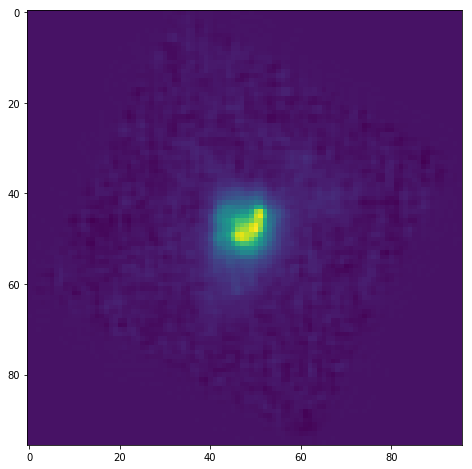

In [398]:
from skimage import restoration
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
testset_file = 'image-shfl-0-multihdu.fits'
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
data_path='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
gauss_ref=fits.getdata('/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits')
#ref=(slice(96,192),slice(96,192)) #for centering
#ref=(slice(96,192),slice(0,96)) #for spiral
ref=(slice(0,96),slice(0,96)) #for test
noise_free_image=fits.getdata(data_path+testset_file,0)[ref]
psf=fits.getdata(data_path+testset_file,1)[ref]
target=fits.getdata(data_path+testset_file,2)[ref]
psf_ctr=recenter_psf(psf,np.array([-0.5,-0.5]))
psf_tar=fits.getdata('/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits')
plt.imshow(noise_free_image)

In [519]:
import scipy.signal
from DeepDeconv.utils.deconv_utils import FISTA,tikhonov
from DeepDeconv.utils.data_utils import add_noise
np.random.seed(0)
SNR_SIMU=20
noisy_im,SNR_list,sigma_list=add_noise(noise_free_image,SNR=SNR_SIMU)
yf=restoration.uft.ufft2(noisy_im)
trans_func = restoration.uft.ir2tf(psf_ctr, noise_free_image.shape, is_real=False)
deconv_im0=np.real(restoration.wiener(noisy_im,trans_func,1/SNR_list[0], is_real=False,clip=False))
tfdirac,imdirac=dirac2d(noisy_im.ndim,noisy_im.shape,is_real=False)
lap_tf, lap_ker = restoration.uft.laplacian(noisy_im.ndim, noisy_im.shape, is_real=False)
lap_tf/=np.linalg.norm(lap_ker,ord='fro')
fullh=np.abs(trans_func)
lst_nonz=np.where(fullh>0)


### See the impact of choosing the orthogonal of the support for SURE Proj

In [520]:
check_hyper=10**np.arange(-2.0,2.0,0.01)

hfstar=np.conj(trans_func)
trans_func_ps=np.abs(trans_func)**2
reg_dirac_ps=np.abs(tfdirac)**2
reg_lap_ps=np.abs(lap_tf)**2
im_ps=np.abs(noisy_im)**2
sigma2=sigma_list[0]**2

lst_thr=10.0**np.arange(-1,-20,-1)
tikho_thr=[]
im_tikho_thr=[]
lap_thr=[]
im_lap_thr=[]
for thr in lst_thr:
    lst_nonz=np.where(trans_func_ps>thr)
    print("Process {0}".format(thr),lst_nonz[0].size)
    h2_nonz=np.abs(trans_func[lst_nonz])**2 #This is |h_w|^2
    l2_nonz=np.abs(lap_tf[lst_nonz])**2 #This is |l_w|^2 in case of laplacian
    d2_nonz=np.abs(tfdirac[lst_nonz])**2 #This is 1 (tikhonov:Dirac kernel)
    y2_nonz=np.abs(restoration.uft.ufft2(noisy_im)[lst_nonz])**2 #This is the FFT of noisy image
    sco=scipy.optimize.minimize(cy_sure_proj_risk_est_1d, 1.0, args=(y2_nonz,h2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2), method='Powell',
                             bounds=(1e-6,100000),options={'xtol': 0.001, 'maxiter': 100, 'disp': True})
    tikho_thr.append(sco.x)
    im_tikho_thr.append(manual_deconv_l2(noisy_im,trans_func,tfdirac,tikho_thr[-1]))
    sco=scipy.optimize.minimize(cy_sure_proj_risk_est_1d, 1.0, args=(y2_nonz,h2_nonz,l2_nonz, y2_nonz.size,sigma_list[0]**2), method='Powell',
                             bounds=(1e-6,100000),options={'xtol': 0.001, 'maxiter': 100, 'disp': True})
    lap_thr.append(sco.x)
    im_lap_thr.append(manual_deconv_l2(noisy_im,trans_func,tfdirac,lap_thr[-1]))



#print(scipy.optimize.minimize(cy_sure_proj_risk_est_1d, 1.0, args=(y2_nonz,h2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2), method='Powell',
#                             bounds=(0,None),options={'xtol': 0.001, 'maxiter': 100, 'disp': True}))
#print(scipy.optimize.minimize_scalar(cy_sure_proj_risk_est_1d, 1.0, args=(y2_nonz,h2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2), method='Bounded',
#                             bounds=(1e-6,100000),options={'xatol': 0.001, 'maxiter': 100, 'disp': True}),'\n')




Process 0.1 665


/local/home/fsureau/miniconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


Optimization terminated successfully.
         Current function value: -2.545798
         Iterations: 1
         Function evaluations: 13
Optimization terminated successfully.
         Current function value: -3.995778
         Iterations: 2
         Function evaluations: 52
Process 0.01 3079
Optimization terminated successfully.
         Current function value: -1.654307
         Iterations: 2
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: -3.988863
         Iterations: 2
         Function evaluations: 55
Process 0.001 4855
Optimization terminated successfully.
         Current function value: -1.176443
         Iterations: 2
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: -3.987825
         Iterations: 2
         Function evaluations: 55
Process 0.0001 5899
Optimization terminated successfully.
         Current function value: -1.443577
         Iterations: 2
         Fu

In [521]:
print(*zip(lst_thr,tikho_thr),"\n")
print(*zip(lst_thr,lap_thr),"\n")

(0.1, array(0.99709123)) (0.01, array(1.70785372)) (0.001, array(2.21906303)) (0.0001, array(1.91416132)) (1e-05, array(1.68714782)) (1e-06, array(1.9350758)) (1e-07, array(2.22490028)) (1e-08, array(1.81676849)) (1e-09, array(2.3422715)) (1e-10, array(2.81119811)) (1e-11, array(2.56293283)) (1e-12, array(3.28857547)) (1e-13, array(3.40923887)) (1e-14, array(3.44168021)) (1e-15, array(3.47766205)) (1e-16, array(3.47137191)) (1e-17, array(3.47137191)) (1e-18, array(3.47137191)) (1e-19, array(3.47137191)) 

(0.1, array(937.81229236)) (0.01, array(952.9233694)) (0.001, array(955.15795334)) (0.0001, array(953.86144228)) (1e-05, array(952.79383018)) (1e-06, array(953.84022953)) (1e-07, array(954.90497584)) (1e-08, array(953.61933427)) (1e-09, array(955.03575553)) (1e-10, array(955.8813735)) (1e-11, array(955.6003175)) (1e-12, array(956.33926512)) (1e-13, array(956.42076448)) (1e-14, array(956.4470333)) (1e-15, array(956.47145842)) (1e-16, array(956.46712389)) (1e-17, array(956.46712389)) (1

In [522]:
check_hyper=10**np.arange(-2.0,2.0,0.01)

hfstar=np.conj(trans_func)
trans_func_ps=np.abs(trans_func)**2
reg_dirac_ps=np.abs(tfdirac)**2
reg_lap_ps=np.abs(lap_tf)**2
im_ps=np.abs(noisy_im)**2
sigma2=sigma_list[0]**2


lst_nonz=np.where(trans_func_ps>1e-6)
h2_nonz=np.abs(trans_func[lst_nonz])**2 #This is |h_w|^2
l2_nonz=np.abs(lap_tf[lst_nonz])**2 #This is |l_w|^2 in case of laplacian
d2_nonz=np.abs(tfdirac[lst_nonz])**2 #This is 1 (tikhonov:Dirac kernel)
y2_nonz=np.abs(restoration.uft.ufft2(noisy_im)[lst_nonz])**2 #This is the FFT of noisy image

sure_proj_risk_1=proj_sure_list(h2_nonz.flatten(),y2_nonz.flatten(),check_hyper,d2_nonz.flatten(),sigma2)
print(np.size(lst_nonz))
print(scipy.optimize.minimize(cy_sure_proj_risk_est_1d, 1.0, args=(y2_nonz,h2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2), method='Powell',
                             bounds=(0,None),options={'xtol': 0.001, 'maxiter': 100, 'disp': True}))
print(scipy.optimize.minimize_scalar(cy_sure_proj_risk_est_1d, 1.0, args=(y2_nonz,h2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2), method='Bounded',
                             bounds=(1e-6,100000),options={'xatol': 0.001, 'maxiter': 100, 'disp': True}),'\n')


lst_nonz=np.where(trans_func_ps>1e-6)
h2_nonz=np.abs(trans_func[lst_nonz])**2 #This is |h_w|^2
l2_nonz=np.abs(lap_tf[lst_nonz])**2 #This is |l_w|^2 in case of laplacian
d2_nonz=np.abs(tfdirac[lst_nonz])**2 #This is 1 (tikhonov:Dirac kernel)
y2_nonz=np.abs(restoration.uft.ufft2(noisy_im)[lst_nonz])**2 #This is the FFT of noisy image

sure_proj_risk_2=proj_sure_list(h2_nonz.flatten(),y2_nonz.flatten(),check_hyper,d2_nonz.flatten(),sigma2)
print(np.size(lst_nonz))
print(scipy.optimize.minimize(cy_sure_proj_risk_est_1d, 1.0, args=(y2_nonz,h2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2), method='Powell',
                             bounds=(0,None),options={'xtol': 0.001, 'maxiter': 100, 'disp': True}))
print(scipy.optimize.minimize_scalar(cy_sure_proj_risk_est_1d, 1.0, args=(y2_nonz,h2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2), method='Bounded',
                             bounds=(1e-6,100000),options={'xatol': 0.001, 'maxiter': 100, 'disp': True}),'\n')



lst_nonz=np.where(trans_func_ps>1e-12)
h2_nonz=np.abs(trans_func[lst_nonz])**2 #This is |h_w|^2
l2_nonz=np.abs(lap_tf[lst_nonz])**2 #This is |l_w|^2 in case of laplacian
d2_nonz=np.abs(tfdirac[lst_nonz])**2 #This is 1 (tikhonov:Dirac kernel)
y2_nonz=np.abs(restoration.uft.ufft2(noisy_im)[lst_nonz])**2 #This is the FFT of noisy image

sure_proj_risk_3=proj_sure_list(h2_nonz.flatten(),y2_nonz.flatten(),check_hyper,d2_nonz.flatten(),sigma2)
print(np.size(lst_nonz))
print(scipy.optimize.minimize(cy_sure_proj_risk_est_1d, 1.0, args=(y2_nonz,h2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2), method='Powell',
                             bounds=(0,None),options={'xtol': 0.001, 'maxiter': 100, 'disp': True}))




13246
Optimization terminated successfully.
         Current function value: -1.422555
         Iterations: 2
         Function evaluations: 30
   direc: array([[0.03615]])
     fun: array(-1.42255517)
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 2
  status: 0
 success: True
       x: array(1.9350758)

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )
     fun: -1.4225551725606638
 message: 'Solution found.'
    nfev: 31
  status: 0
 success: True
       x: 1.9351349828722118 

13246
Optimization terminated successfully.
         Current function value: -1.422555
         Iterations: 2
         Function evaluations: 30
   direc: array([[0.03615]])
     fun: array(-1.42255517)
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 2
  status: 0
 success: True
       x: array(1.9350758)

Optimization terminated successfully;
The returned value satisfies the termination criteria


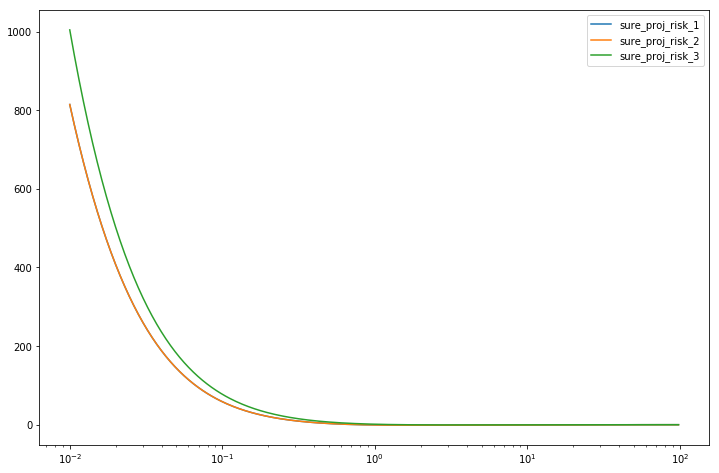

In [523]:
plt.plot(check_hyper,sure_proj_risk_1,label="sure_proj_risk_1")
plt.plot(check_hyper,sure_proj_risk_2,label="sure_proj_risk_2")
plt.plot(check_hyper,sure_proj_risk_3,label="sure_proj_risk_3")
plt.legend()
plt.xscale('log')



### Comparison of residuals

In [524]:
def manual_deconv_l2(noisy_im,trans_func,trans_reg,hyp_param):
    hfstar=np.conj(trans_func)
    h2=np.abs(trans_func)**2
    d2=np.abs(trans_reg)**2
    filter_f=hfstar/(h2+hyp_param*d2)#/SNR_list[0]
    yf_noisy=restoration.uft.ufft2(noisy_im)
    sol=np.real(restoration.uft.uifft2(filter_f*yf_noisy))
    return sol

def construct_MSE_curve_list(noise_free_im,SNR_SIMU,trans_func,trans_reg,hyp_param_list,nrea):
    MSE_LIST=np.zeros((len(hyp_param_list),nrea))
    for khyp,hyp_param in enumerate(hyp_param_list):
        for krea in range(nrea):
            noisy_im,_,_=add_noise(noise_free_im,SNR=SNR_SIMU)
            sol=manual_deconv_l2(noisy_im,trans_func,trans_reg,hyp_param)
            MSE_LIST[khyp,krea]=np.linalg.norm(sol-noise_free_im,ord='fro')**2   
    return MSE_LIST

def construct_MSE_curve_list_fft(noise_free_im,SNR_SIMU,trans_func,trans_reg,hyp_param_list,nrea):
    MSE_LIST=np.zeros((len(hyp_param_list),nrea,3))
    yf_noisefree=restoration.uft.ufft2(noise_free_im)
    yf_conv_noisefree=trans_func*yf_noisefree
    noise_free_conv=np.real(restoration.uft.uifft2(yf_conv_noisefree))
    hfstar=np.conj(trans_func)
    h2=np.abs(trans_func)**2
    d2=np.abs(trans_reg)**2
    for khyp,hyp_param in enumerate(hyp_param_list):
        filter_f=hfstar/(h2+hyp_param*d2)#/SNR_list[0]
        for krea in range(nrea):
            noisy_im,_,_=add_noise(noise_free_conv,SNR=SNR_SIMU)
            yf_noisy=restoration.uft.ufft2(noisy_im)
            MSE_LIST[khyp,krea,0]=np.sum(np.abs(filter_f*yf_noisy)**2)
            MSE_LIST[khyp,krea,1]=-2*np.real(np.vdot((filter_f*yf_noisy),yf_noisefree))
            MSE_LIST[khyp,krea,2]=-2*np.abs(np.vdot(yf_noisy,yf_conv_noisefree))
            #print(np.vdot((filter_f*yf),yf_noisefree))
    return MSE_LIST

def construct_MSE_curve_list_both(noise_free_im,SNR_SIMU,trans_func,trans_reg,hyp_param_list,nrea):
    MSE_LIST=np.zeros((len(hyp_param_list),nrea,2))
    yf_noisefree=restoration.uft.ufft2(noise_free_im)
    hfstar=np.conj(trans_func)
    h2=np.abs(trans_func)**2
    d2=np.abs(trans_reg)**2
    for khyp,hyp_param in enumerate(hyp_param_list):
        filter_f=hfstar/(h2+hyp_param*d2)#/SNR_list[0]
        for krea in range(nrea):
            noisy_im,_,_=add_noise(noise_free_im,SNR=SNR_SIMU)
            sol=manual_deconv_l2(noisy_im,trans_func,trans_reg,hyp_param)
            yf_noisy=restoration.uft.ufft2(noisy_im)
            MSE_LIST[khyp,krea,0]=np.sum(np.abs((filter_f*yf_noisyyf-yf_noisefree)**2))
            MSE_LIST[khyp,krea,1]=np.linalg.norm(sol-noise_free_im,ord='fro')**2             
    return MSE_LIST


def proj_sure_terms(h2,y2,x,reg2,sigma2):
    den=h2+x*reg2
    den2=den**2
    return np.array([np.sum(h2*y2/den2),np.sum(2.0*(sigma2/den)),np.sum(-2*y2/den),2.0*np.sum(sigma2-y2)])

def proj_sure_list_terms(h2,y2,xlist,reg2,sigma2):
    return np.array([proj_sure_terms(h2,y2,x,reg2,sigma2) for x in xlist])




In [613]:
check_hyper=10**np.arange(-2.0,2.5,0.1)
nrea=100
SNR_SIMU=100
hfstar=np.conj(trans_func)
trans_func_ps=np.abs(trans_func)**2
reg_dirac_ps=np.abs(tfdirac)**2
reg_lap_ps=np.abs(lap_tf)**2 #To have a 1 norm for the kernel
im_ps=np.abs(noisy_im)**2
noisy_im,SNR_list,sigma_list=add_noise(noise_free_image,SNR=SNR_SIMU)
sigma2=sigma_list[0]**2


import timeit
#tic = timeit.default_timer()
#MSE_dirac=construct_MSE_curve_list(noise_free_image,SNR_SIMU,trans_func,reg_dirac_ps,check_hyper,4)
#toc = timeit.default_timer()
#print("PYTHON BACK/FORTH=",toc-tic,np.min(check_hyper[np.argmin(np.mean(MSE_dirac,axis=1))]))
tic = timeit.default_timer()
MSE_dirac2=construct_MSE_curve_list_fft(noise_free_image,SNR_SIMU,trans_func,tfdirac,check_hyper,nrea)
toc = timeit.default_timer()
MSE_dirac2_for_sure=np.mean(MSE_dirac2,axis=1)
print("PYTHON FORTH=",toc-tic,np.min(check_hyper[np.argmin(np.mean(MSE_dirac2,axis=1))]))
tic = timeit.default_timer()
MSE_lap2=construct_MSE_curve_list_fft(noise_free_image,SNR_SIMU,trans_func,lap_tf,check_hyper,nrea)
toc = timeit.default_timer()
print("PYTHON FORTH=",toc-tic,np.min(check_hyper[np.argmin(np.mean(MSE_lap2,axis=1))]))
MSE_lap2_for_sure=np.mean(MSE_lap2,axis=1)

PYTHON FORTH= 20.628683819435537 0.012589254117941675
PYTHON FORTH= 20.574055390432477 0.012589254117941675


In [614]:
lst_nonz=np.where(trans_func_ps>1e-3)
h2_nonz=np.abs(trans_func[lst_nonz])**2 #This is |h_w|^2
l2_nonz=np.abs(lap_tf[lst_nonz])**2 #This is |l_w|^2 in case of laplacian
d2_nonz=np.abs(tfdirac[lst_nonz])**2 #This is 1 (tikhonov:Dirac kernel)

nrea=100

yf_noisefree=restoration.uft.ufft2(noise_free_image)
yf_conv_noisefree=trans_func*yf_noisefree
noise_free_conv=np.real(restoration.uft.uifft2(yf_conv_noisefree))



sure_tikho=[]
sure_lap=[]
tic = timeit.default_timer()
for k in range(nrea):
    noisy_im,SNR_list,sigma_list=add_noise(noise_free_conv,SNR=SNR_SIMU)
    sigma2=sigma_list[0]**2
    y2_nonz=np.abs(restoration.uft.ufft2(noisy_im)[lst_nonz])**2 #This is the FFT of noisy image
    sure_tikho.append(np.array(proj_sure_list_terms(h2_nonz.flatten(),y2_nonz.flatten(),check_hyper,d2_nonz.flatten(),sigma2)))
    sure_lap.append(np.array(proj_sure_list_terms(h2_nonz.flatten(),y2_nonz.flatten(),check_hyper,l2_nonz.flatten(),sigma2)))

toc = timeit.default_timer()
print("PYTHON FORTH=",toc-tic)

    
sure_tikho=np.array(sure_tikho)
sure_lap=np.array(sure_lap)


PYTHON FORTH= 2.2274859212338924


In [615]:
print(MSE_dirac2_for_sure[:,2],np.mean(sure_tikho[:,:,3])) # This is -2*np.abs(np.vdot(yf_noisy,yf_conv_noisefree)) and 2.0*np.sum(sigma2-y2)


[-5.51450876 -5.51651227 -5.51915714 -5.51548874 -5.50805502 -5.51051826
 -5.51819949 -5.50929325 -5.52070521 -5.50825414 -5.52339267 -5.51606136
 -5.51990379 -5.52129397 -5.52090476 -5.52217899 -5.53162994 -5.5099258
 -5.52037768 -5.51531791 -5.5181571  -5.51650104 -5.51594514 -5.51267492
 -5.51125059 -5.51528773 -5.5123095  -5.51867793 -5.51469262 -5.51392765
 -5.52442266 -5.51756893 -5.52042388 -5.51787214 -5.51350501 -5.51595714
 -5.52266526 -5.50397021 -5.5203074  -5.52282474 -5.51073793 -5.51847746
 -5.51557381 -5.51406794 -5.5193714 ] -5.50641506772118


In [616]:
print(MSE_lap2_for_sure[:,2],np.mean(sure_lap[:,:,3]))# This is -2*np.abs(np.vdot(yf_noisy,yf_conv_noisefree)) and 2.0*np.sum(sigma2-y2)

[-5.52484358 -5.51499969 -5.51591797 -5.52104702 -5.51564618 -5.5085909
 -5.52044819 -5.52065658 -5.51674172 -5.51344471 -5.52495089 -5.52120848
 -5.51657126 -5.52367551 -5.52015864 -5.51817838 -5.51867135 -5.50775396
 -5.52115333 -5.51764338 -5.51886951 -5.51980184 -5.51391856 -5.52042388
 -5.5069756  -5.5235086  -5.52257382 -5.51679859 -5.52174319 -5.52236044
 -5.50959753 -5.52448586 -5.50907231 -5.52314813 -5.52934464 -5.52097678
 -5.52289888 -5.51244791 -5.51571543 -5.51123488 -5.50528996 -5.51447917
 -5.5198191  -5.51832802 -5.52096878] -5.50641506772118


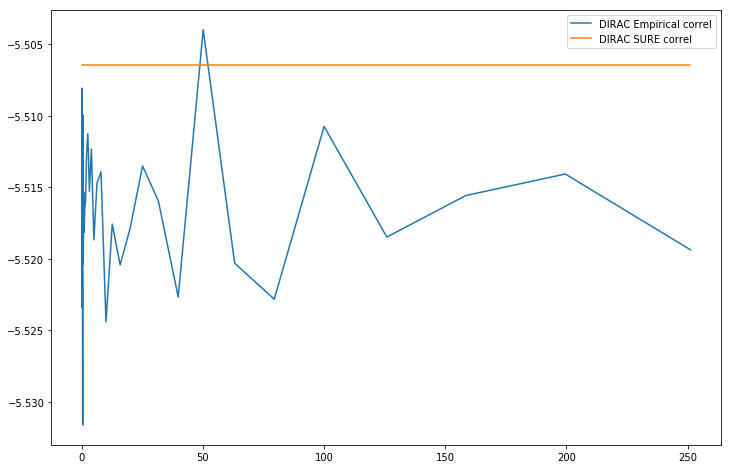

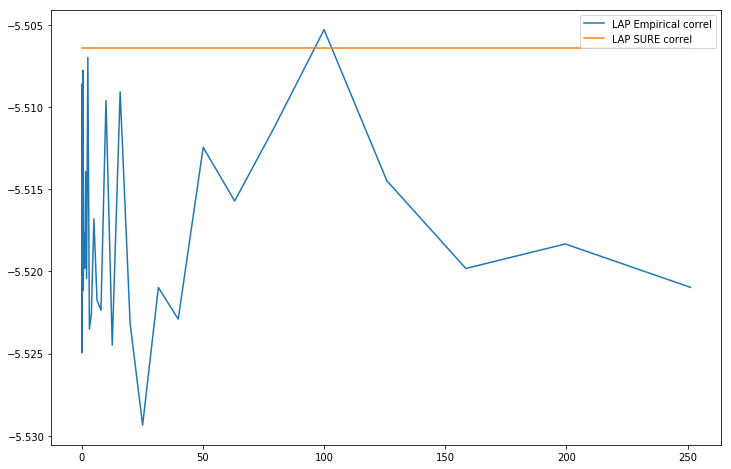

In [617]:
plt.figure()
plt.plot(check_hyper,MSE_dirac2_for_sure[:,2],label="DIRAC Empirical correl")
plt.plot(check_hyper,np.mean(sure_tikho[:,:,3],axis=0),label="DIRAC SURE correl")
plt.legend()
plt.figure()
plt.plot(check_hyper,MSE_lap2_for_sure[:,2],label="LAP Empirical correl")
plt.plot(check_hyper,np.mean(sure_lap[:,:,3],axis=0),label="LAP SURE correl")
plt.legend()

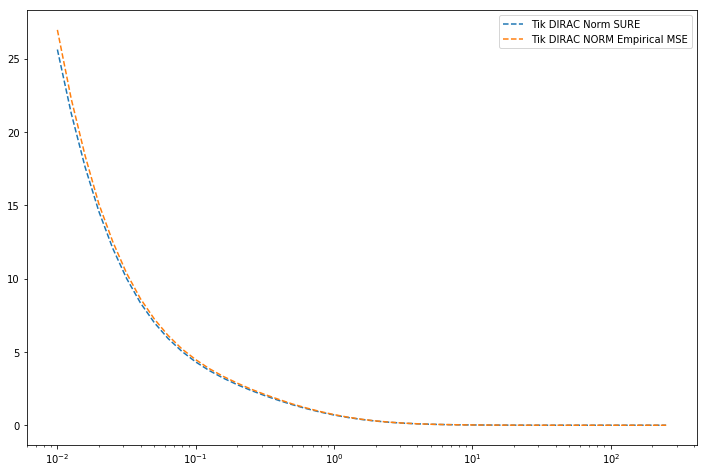

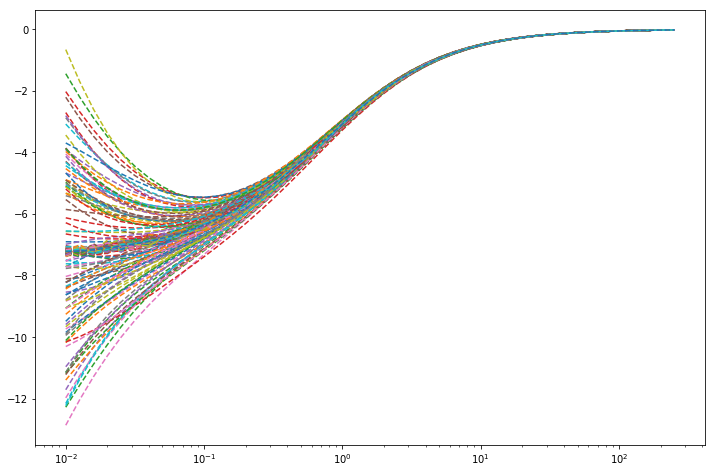

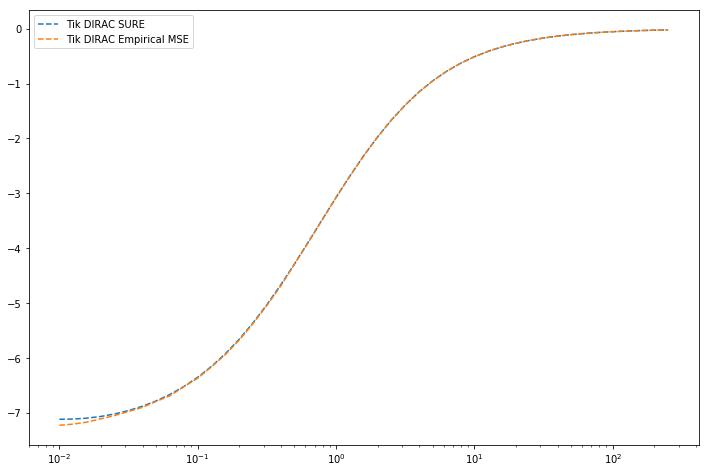

In [618]:
plt.figure()
plt.plot(check_hyper,sure_tikho[0,:,0],'--',label="Tik DIRAC Norm SURE")
plt.plot(check_hyper,MSE_dirac2_for_sure[:,0],'--',label="Tik DIRAC NORM Empirical MSE")
plt.xscale('log')
plt.legend()

plt.figure()
plt.plot(check_hyper,(sure_tikho[0:100,:,1]+sure_tikho[0:100,:,2]).T,'--',label="Tik DIRAC SURE Correl")
plt.plot(check_hyper,MSE_dirac2[:,:,1],'--',label="Tik DIRAC Correl ALL EST")
plt.plot(check_hyper,MSE_dirac2_for_sure[:,1],'--',label="Tik DIRAC Empirical MSE")
plt.xscale('log')

plt.figure()
plt.plot(check_hyper,np.mean((sure_tikho[:,:,1]+sure_tikho[:,:,2]),axis=0),'--',label="Tik DIRAC SURE")
plt.plot(check_hyper,MSE_dirac2_for_sure[:,1],'--',label="Tik DIRAC Empirical MSE")
plt.xscale('log')
plt.legend()




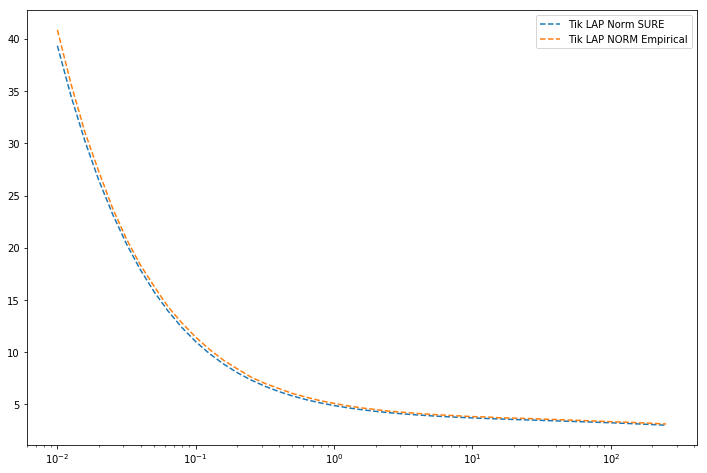

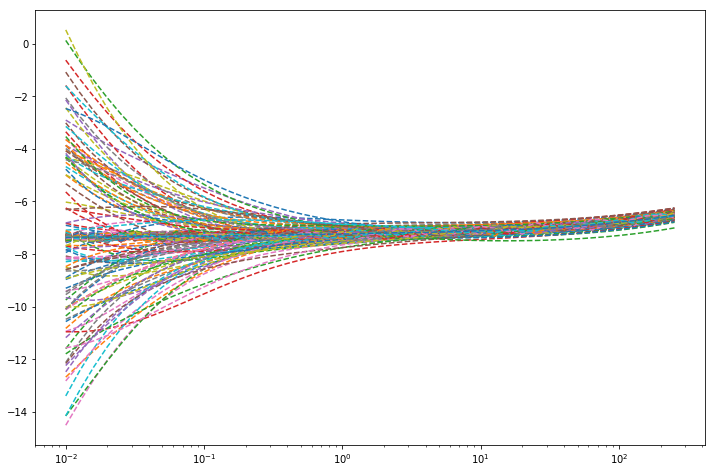

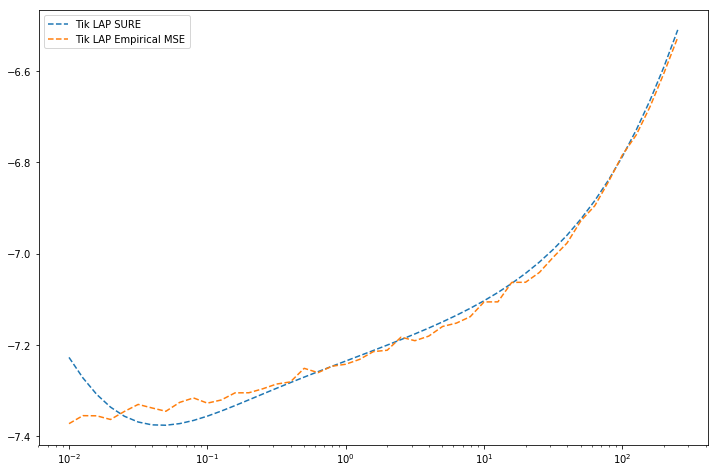

In [619]:
plt.figure()
plt.plot(check_hyper,sure_lap[0,:,0],'--',label="Tik LAP Norm SURE")
plt.plot(check_hyper,MSE_lap2_for_sure[:,0],'--',label="Tik LAP NORM Empirical")
plt.xscale('log')
plt.legend()

plt.figure()
plt.plot(check_hyper,(sure_lap[0:100,:,1]+sure_lap[0:100,:,2]).T,'--',label="Tik LAP SURE Correl")
plt.plot(check_hyper,MSE_lap2[:,:,1],'--',label="Tik LAP Correl ALL EST")
plt.plot(check_hyper,MSE_lap2_for_sure[:,1],'--',label="Tik LAP Empirical MSE")
plt.xscale('log')

plt.figure()
plt.plot(check_hyper,np.mean((sure_lap[:,:,1]+sure_lap[:,:,2]),axis=0),'--',label="Tik LAP SURE")
plt.plot(check_hyper,MSE_lap2_for_sure[:,1],'--',label="Tik LAP Empirical MSE")
plt.xscale('log')
plt.legend()





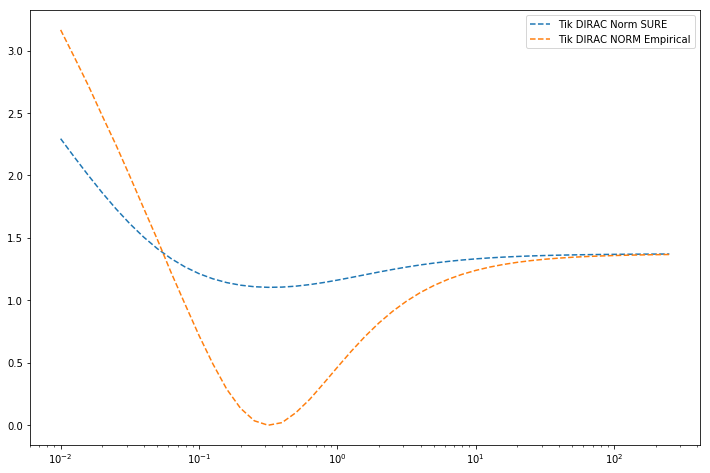

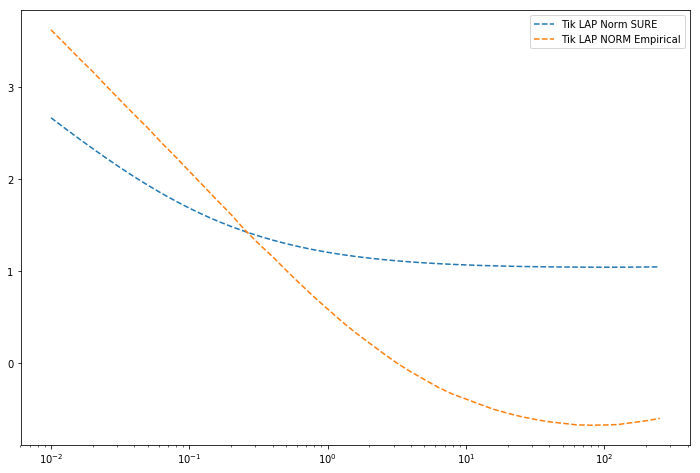

In [621]:
plt.figure()
msure_dirac_tikho=np.mean(sure_tikho[0,:,0:3],axis=1)
memp_dirac_tikho=MSE_dirac2_for_sure[:,0]+MSE_dirac2_for_sure[:,1]
common_dirac_min=np.min((msure_dirac_tikho,memp_dirac_tikho))
plt.plot(check_hyper,np.log(msure_dirac_tikho-common_dirac_min+1),'--',label="Tik DIRAC Norm SURE")
plt.plot(check_hyper,np.log(memp_dirac_tikho-common_dirac_min+1),'--',label="Tik DIRAC NORM Empirical")
plt.xscale('log')
plt.legend()


plt.figure()
msure_lap_tikho=np.mean(sure_lap[0,:,0:3],axis=1)
memp_lap_tikho=MSE_lap2_for_sure[:,0]+MSE_lap2_for_sure[:,1]
common_lap_min=np.min((msure_lap_tikho,memp_lap_tikho))


plt.plot(check_hyper,np.log(msure_lap_tikho-common_dirac_min+1),'--',label="Tik LAP Norm SURE")
plt.plot(check_hyper,np.log(memp_lap_tikho-common_dirac_min+1),'--',label="Tik LAP NORM Empirical")
plt.xscale('log')
plt.legend()





In [ ]:
print(check_hyper[np.argmin(MSE_dirac2_for_sure[:,0]+MSE_dirac2_for_sure[:,1])])
print(check_hyper[np.argmin(np.mean(sure_tikho[0,:,0:3],axis=1))])

print(check_hyper[np.argmin(MSE_lap2_for_sure[:,0]+MSE_lap2_for_sure[:,1])])
print(check_hyper[np.argmin(np.mean(sure_lap[0,:,0:3],axis=1))])

In conclusion: As shown by Pesquet, the SURE estimator is very noisy in particular when the thresholds are low, which gives rise to wrong 

## Timing performance

### Dependence on minimizer

In [34]:
import timeit
check_hyper=10**np.arange(-5.0,2.0,0.1)
tic = timeit.default_timer()
sure_proj_risk=_sure_proj_risk_est_2d(im_ps,trans_func_ps,reg_dirac_ps,check_hyper,sigma2)
toc = timeit.default_timer()
print("PYTHON=",toc-tic,np.min(check_hyper[np.argmin(sure_proj_risk)]))

tic = timeit.default_timer()
print(scipy.optimize.minimize(cy_sure_proj_risk_est_1d, 1.0, args=(y2_nonz,h2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2), method='Powell',
                             options={'xtol': 0.001, 'maxiter': 100, 'disp': True}))
toc = timeit.default_timer()
print("CYTHON MIN=",toc-tic)
tic = timeit.default_timer()
print(scipy.optimize.minimize_scalar(cy_sure_proj_risk_est_1d, 1.0, args=(y2_nonz,h2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2), method='Bounded',
                             bounds=(1e-6,100000),options={'xatol': 0.001, 'maxiter': 100, 'disp': True}),'\n')

toc = timeit.default_timer()
print("CYTHON2 MIN=",toc-tic)



PYTHON= 0.015006761997938156 1e-05
Optimization terminated successfully.
         Current function value: -0.604321
         Iterations: 2
         Function evaluations: 30
   direc: array([[0.12267935]])
     fun: array(-0.6043209)
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 2
  status: 0
 success: True
       x: array(3.47137191)
CYTHON MIN= 0.0037631485611200333

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )
     fun: -0.6043209027994817
 message: 'Solution found.'
    nfev: 32
  status: 0
 success: True
       x: 3.471446864232836 

CYTHON2 MIN= 0.003549806773662567


Check which code Alexis was using from skimage

#### Manual implementation of Hunt/Tikhonov deconv

In [20]:
def manual_deconv_l2(noisy_im,trans_func,trans_reg,hyp_param):
    hfstar=np.conj(trans_func)
    h2=np.abs(trans_func)**2
    d2=np.abs(trans_reg)**2
    filter_f=hfstar/(h2+hyp_param*d2)#/SNR_list[0]
    yf=restoration.uft.ufft2(noisy_im)
    sol=np.real(restoration.uft.uifft2(filter_f*yf))
    return sol

### Check SURE

#### Set up useful variables in fourier space

In [22]:
h2=np.abs(trans_func)**2 #This is |h_w|^2
l2=np.abs(lap_tf)**2 #This is |l_w|^2 in case of laplacian
d2=np.abs(tfdirac)**2 #This is 1 (tikhonov:Dirac kernel)
y2z=np.abs(restoration.uft.ufft2(noisy_im))**2 #This is the FFT of noisy image

h2_nonz=np.abs(trans_func[lst_nonz])**2 #This is |h_w|^2
l2_nonz=np.abs(lap_tf[lst_nonz])**2 #This is |l_w|^2 in case of laplacian
d2_nonz=np.abs(tfdirac[lst_nonz])**2 #This is 1 (tikhonov:Dirac kernel)
y2_nonz=np.abs(restoration.uft.ufft2(noisy_im)[lst_nonz])**2 #This is the FFT of noisy image

In [30]:
np.min(y2z)

9.983322444277194e-07

#### SURE estimation risk

5.011872336272489 79.43282347242366 0.05 -4.088958700672787


(<matplotlib.axes._subplots.AxesSubplot at 0x7f944164a320>,
 Text(0.5, 1.0, 'Wiener Proj SURE'))

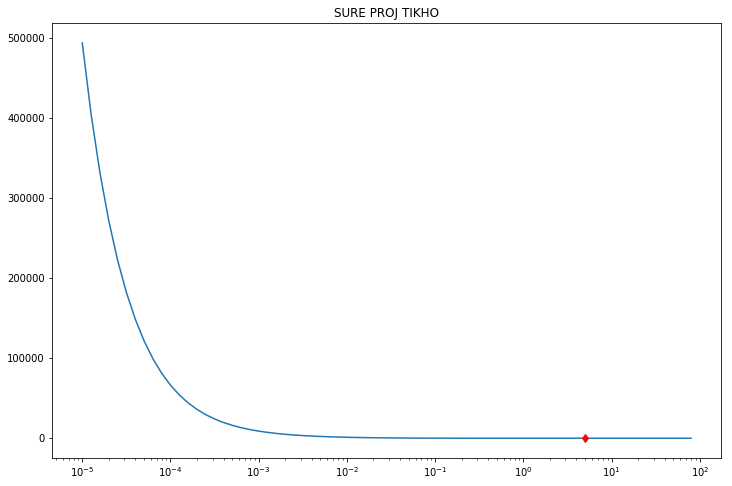

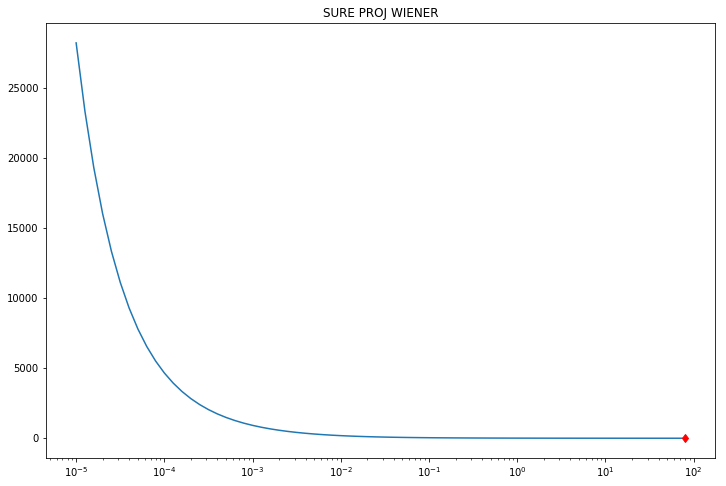

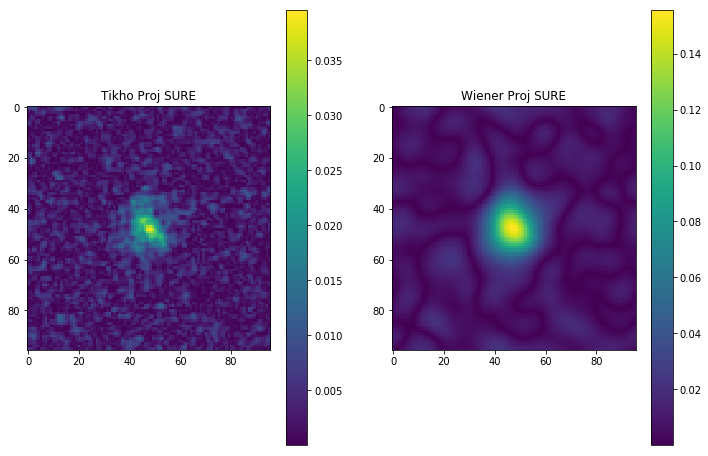

In [32]:
def proj_sure(h2,y2,x,reg2,sigma2):
    den=h2+x*reg2
    den2=den**2
    return np.sum(h2*y2/den2+2.0*(sigma2-y2)/den)

res_sure_proj_tikho=np.array([[x,proj_sure(h2_nonz,y2_nonz,x,d2_nonz,sigma_list[0]**2)] for x in check_hyper])
tau_sure_proj_tikho=res_sure_proj_tikho[np.argmin(res_sure_proj_tikho[:,1])][0]

res_sure_proj_wiener=np.array([[x,proj_sure(h2_nonz,y2_nonz,x,l2_nonz,sigma_list[0]**2)] for x in check_hyper])
tau_sure_proj_wiener=res_sure_proj_wiener[np.argmin(res_sure_proj_wiener[:,1])][0]


# proj_sure_tikho = lambda x: np.sum(h2_nonz*y2_nonz/((h2_nonz+x*d2_nonz)**2)+2.0*(sigma_list[0]**2-y2_nonz)/(h2_nonz+x*d2_nonz))
# proj_sure_wiener = lambda x: np.sum(h2_nonz*y2_nonz/((h2_nonz+x*l2_nonz)**2)+2.0*(sigma_list[0]**2-y2_nonz)/(h2_nonz+x*l2_nonz))

# res_sure_proj_tikho=np.array([[10**x,proj_sure_tikho(10**x)] for x in np.arange(-6.0,2.0,0.1)])
# tau_sure_proj_tikho=res_sure_proj_tikho[np.argmin(res_sure_proj_tikho[:,1])][0]

# res_sure_proj_wiener=np.array([[10**x,proj_sure_wiener(10**x)] for x in np.arange(-6.0,2.0,0.1)])
# tau_sure_proj_wiener=res_sure_proj_wiener[np.argmin(res_sure_proj_wiener[:,1])][0]


print(tau_sure_proj_tikho,tau_sure_proj_wiener,1/SNR_list[0],np.min(res_sure_proj_wiener[:,1]))

plt.figure()
plt.plot(res_sure_proj_tikho[:,0],res_sure_proj_tikho[:,1]),plt.title("SURE PROJ TIKHO")
plt.plot([tau_sure_proj_tikho],[res_sure_proj_tikho[np.argmin(res_sure_proj_tikho[:,1])][1]],'rd')
plt.xscale('log')
plt.figure()
plt.plot(res_sure_proj_wiener[:,0],res_sure_proj_wiener[:,1]),plt.title("SURE PROJ WIENER")
plt.plot([tau_sure_proj_wiener],[res_sure_proj_wiener[np.argmin(res_sure_proj_wiener[:,1])][1]],'rd')
plt.xscale('log')
plt.figure()

skimage_sure_proj_tikho=restoration.wiener(noisy_im,trans_func,tau_sure_proj_tikho,reg=tfdirac, is_real=False,clip=False)
skimage_sure_proj_wiener=restoration.wiener(noisy_im,trans_func,tau_sure_proj_wiener,reg=lap_tf, is_real=False,clip=False)
plt.subplot(121),plt.imshow(np.abs(skimage_sure_proj_tikho)),plt.colorbar(),plt.title("Tikho Proj SURE")
plt.subplot(12),plt.imshow(np.abs(skimage_sure_proj_wiener)),plt.colorbar(),plt.title("Wiener Proj SURE")


#### Predicted SURE Risk Estimation

0.7943282347242496 79.43282347242366 0.05 -3.6132142500989888


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2317e65c18>,
 Text(0.5, 1.0, 'Wiener Pred SURE'))

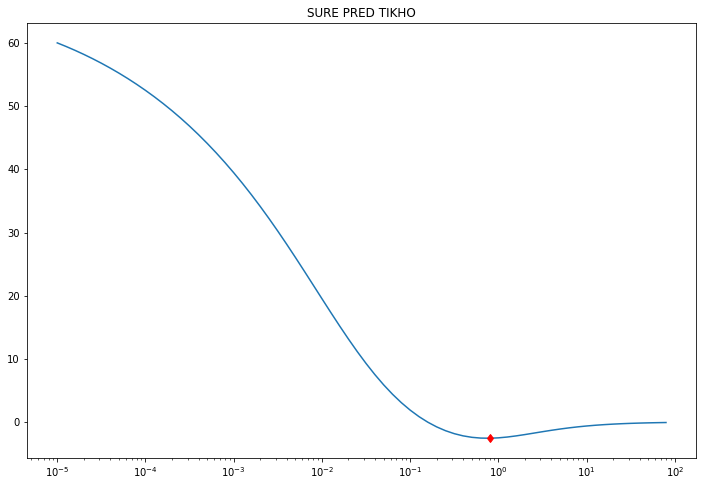

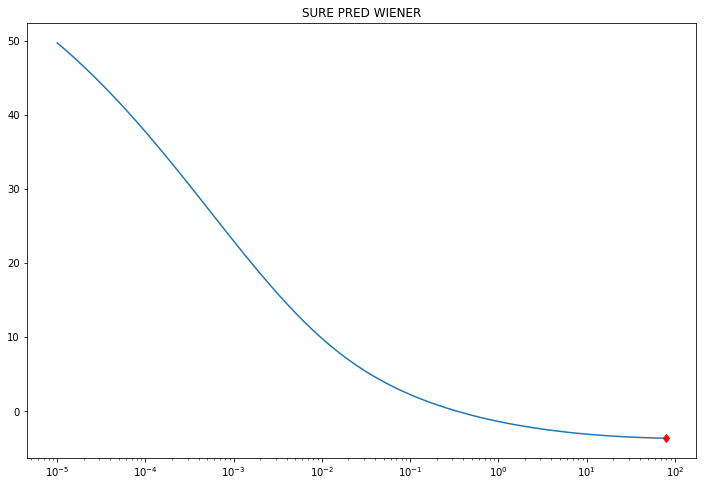

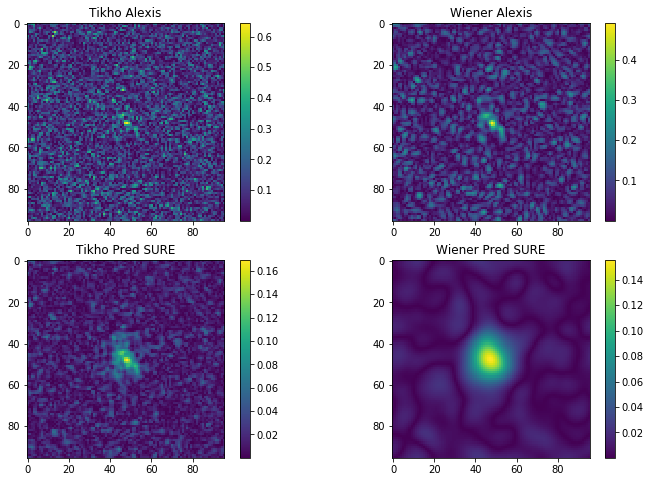

In [541]:
def pred_risk_est0(im_fft,h2,reg2,tau,sigma):
    wiener_f=h2/(h2+tau*reg2)
    res=np.sum(np.abs(im_fft*(1.0-wiener_f))**2)
    tr_res=-(sigma**2) * np.sum((1.0-wiener_f)**2)
    tr=(sigma**2) * np.sum((wiener_f)**2)
    return res+tr+tr_res

def pred_risk_est(im_fft,h2,reg2,tau,sigma):
    wiener_f=h2/(h2+tau*reg2)
    wiener_f2=wiener_f**2
    im_fft_2=np.abs(im_fft)**2
    t1=np.sum(wiener_f2 * im_fft_2)
    t2=2.0*(sigma**2) * np.sum(wiener_f)
    t3=-2* np.sum(wiener_f*np.abs(im_fft)**2)
    return t1+t2+t3


res_sure_pred_risk_tikho=np.array([[x,pred_risk_est(yf,h2,d2,x,sigma_list[0])] for x in check_hyper])
tau_sure_pred_tikho=res_sure_pred_risk_tikho[np.argmin(res_sure_pred_risk_tikho[:,1])][0]

res_sure_pred_risk_wiener=np.array([[x,pred_risk_est(yf,h2,l2,x,sigma_list[0])] for x in check_hyper])
tau_sure_pred_wiener=res_sure_pred_risk_wiener[np.argmin(res_sure_pred_risk_wiener[:,1])][0]

print(tau_sure_pred_tikho,tau_sure_pred_wiener,1/SNR_list[0],np.min(res_sure_pred_risk_wiener) )

plt.figure()
plt.plot(res_sure_pred_risk_tikho[:,0],res_sure_pred_risk_tikho[:,1]),plt.title("SURE PRED TIKHO")
plt.plot([tau_sure_pred_tikho],[res_sure_pred_risk_tikho[np.argmin(res_sure_pred_risk_tikho[:,1])][1]],'rd')
plt.xscale('log')
plt.figure()
plt.plot(res_sure_pred_risk_wiener[:,0],res_sure_pred_risk_wiener[:,1]),plt.title("SURE PRED WIENER")
plt.plot([tau_sure_pred_wiener],[res_sure_pred_risk_wiener[np.argmin(res_sure_pred_risk_wiener[:,1])][1]],'rd')
plt.xscale('log')
plt.figure()
skimage_sure_pred_tikho=restoration.wiener(noisy_im,trans_func,tau_sure_pred_tikho,reg=tfdirac, is_real=False,clip=False)
skimage_sure_pred_wiener=restoration.wiener(noisy_im,trans_func,tau_sure_pred_wiener,reg=lap_tf, is_real=False,clip=False)
plt.subplot(221),plt.imshow(np.abs(sol_tik)),plt.colorbar(),plt.title("Tikho Alexis")
plt.subplot(222),plt.imshow(np.abs(sol_wien)),plt.colorbar(),plt.title("Wiener Alexis")
plt.subplot(223),plt.imshow(np.abs(skimage_sure_pred_tikho)),plt.colorbar(),plt.title("Tikho Pred SURE")
plt.subplot(224),plt.imshow(np.abs(skimage_sure_pred_wiener)),plt.colorbar(),plt.title("Wiener Pred SURE")



### Generalized cross-validation

0.6309573444801685 
 79.43282347242366


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2316e4f828>,
 Text(0.5, 1.0, 'Wiener GCV'))

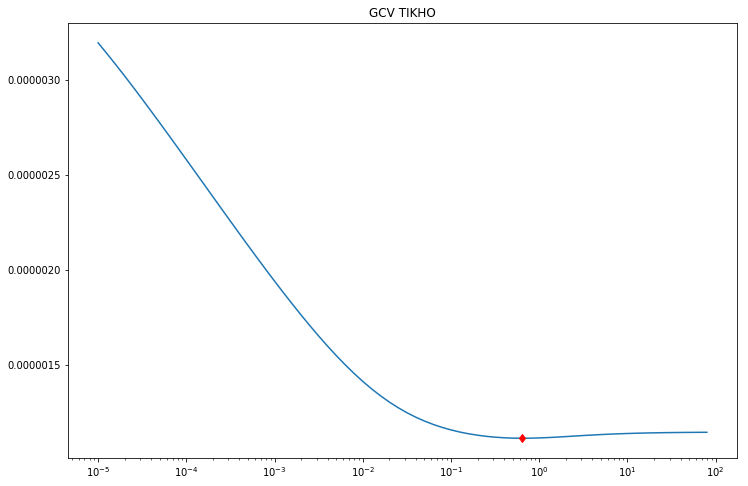

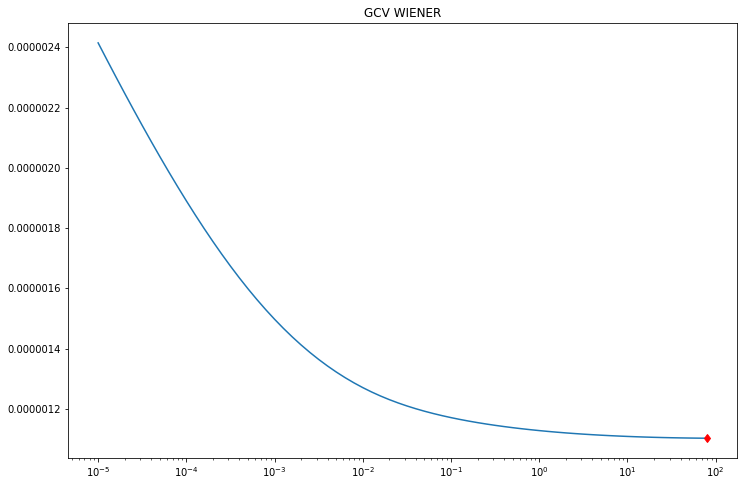

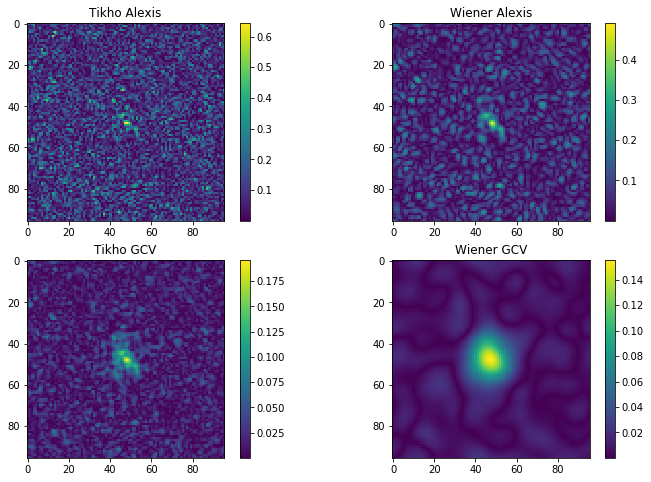

In [542]:
def gcv(im_fft,h2,reg2,tau):
    hfstar=np.conj(trans_func)
    wiener_f=h2/(h2+tau*reg2)
    res=np.sum(np.abs(im_fft)**2*(1.0-wiener_f)**2)
    tr=np.sum(1.0-wiener_f)**2
    return res/tr

res_gcv_tikho=np.array([[x,gcv(yf,h2,d2,x)] for x in check_hyper])
tau_tikho_gcv=res_gcv_tikho[np.argmin(res_gcv_tikho[:,1])][0]
res_gcv_wiener=np.array([[x,gcv(yf,h2,l2,x)] for x in check_hyper])
tau_wiener_gcv=res_gcv_wiener[np.argmin(res_gcv_wiener[:,1])][0]

print(tau_tikho_gcv,'\n',tau_wiener_gcv)

skimage_gcv_tikho=restoration.wiener(noisy_im,trans_func,tau_tikho_gcv,reg=tfdirac, is_real=False,clip=False)
skimage_gcv_wiener=restoration.wiener(noisy_im,trans_func,tau_wiener_gcv,reg=lap_tf, is_real=False,clip=False)

plt.figure()
plt.plot(res_gcv_tikho[:,0],res_gcv_tikho[:,1]),plt.title("GCV TIKHO")
plt.plot([tau_tikho_gcv],[res_gcv_tikho[np.argmin(res_gcv_tikho[:,1])][1]],'rd')
plt.xscale('log')
plt.figure()
plt.plot(res_gcv_wiener[:,0],res_gcv_wiener[:,1]),plt.title("GCV WIENER")
plt.plot([tau_wiener_gcv],[res_gcv_wiener[np.argmin(res_gcv_wiener[:,1])][1]],'rd')
plt.xscale('log')
plt.figure()


plt.subplot(221),plt.imshow(np.abs(sol_tik)),plt.colorbar(),plt.title("Tikho Alexis")
plt.subplot(222),plt.imshow(np.abs(sol_wien)),plt.colorbar(),plt.title("Wiener Alexis")
plt.subplot(223),plt.imshow(np.abs(skimage_gcv_tikho)),plt.colorbar(),plt.title("Tikho GCV")
plt.subplot(224),plt.imshow(np.abs(skimage_gcv_wiener)),plt.colorbar(),plt.title("Wiener GCV")


### Now test Pereyra Bayesian approach

In [543]:
def lambda_pereyra(noisy_im,trans_func,tau0,sigma,reg,nit=10,alpha=1,beta=1):
    tau_list=[tau0]
    tau_cur=tau0
    sigma2=sigma**2
    h2=np.abs(trans_func)**2 #This is |h_w|^2
    reg2=np.abs(reg)**2 #This is |l_w|^2 in case of laplacian
    y2=np.abs(restoration.uft.ufft2(noisy_im))**2 #This is the FFT of noisy image
    n_im=np.size(noisy_im)
    for kit in range(nit):
        deconv0=restoration.wiener(noisy_im,trans_func,tau_cur*sigma2,reg=reg, is_real=False,clip=False)
        deconv_lap=restoration.uft.uifft2(reg*restoration.uft.ufft2(deconv0))
        tau_cur=(n_im/2.0 + alpha - 1.0)/(np.linalg.norm(deconv_lap,ord='fro')**2+beta)
        tau_list.append(tau_cur)
    return np.array(tau_list)*sigma2
 
def lambda_pereyra_fourier(noisy_im,trans_func,tau0,sigma,reg,nit=10,alpha=1,beta=1):
    tau_list=[tau0]
    tau_cur=tau0
    sigma2=sigma**2
    h2=np.abs(trans_func)**2 #This is |h_w|^2
    reg2=np.abs(reg)**2 #This is |l_w|^2 in case of laplacian
    y2=np.abs(restoration.uft.ufft2(noisy_im))**2 #This is the FFT of noisy image
    n_im=np.size(noisy_im)
    num_f=h2*reg2*y2
    for kit in range(nit):
        deconvf2=num_f/(h2+tau_cur*sigma2*reg2)**2
        tau_cur=(n_im/2.0 + alpha - 1.0)/(np.sum(deconvf2)+beta)
        tau_list.append(tau_cur)
    return np.array(tau_list)*sigma2
#Note: gamma prior implies$ mean=\alpha/\beta$, and $var=\alpha/(\beta^2)$  
#tau_pereyra_wiener=lambda_pereyra(noisy_im,trans_func,1/sigma_list[0]**2,sigma_list[0],lap_tf,nit=20,alpha=1,beta=1)
#tau_pereyra_wiener_fourier=lambda_pereyra_fourier(noisy_im,trans_func,1,sigma_list[0],lap_tf,nit=20,alpha=1,beta=1)

tau_pereyra_tikho=lambda_pereyra_fourier(noisy_im,trans_func,1,sigma_list[0],lap_tf,nit=20,alpha=1,beta=1)
tau_pereyra_wiener=lambda_pereyra_fourier(noisy_im,trans_func,1,sigma_list[0],tfdirac,nit=20,alpha=1,beta=1)


In [544]:
print('Tikho SNR:',SNR_list[0],'\n',"GCV=",tau_tikho_gcv,'\n',"SURE PRED=",tau_sure_pred_tikho,'\n',"SURE PROJ=",tau_sure_proj_tikho,'\n',"PEREYRA GAMMA=",tau_pereyra_tikho[-1],'\n\n')
print('Wiener SNR:',SNR_list[0],'\n',"GCV=",tau_wiener_gcv,'\n',"SURE PRED=",tau_sure_pred_wiener,'\n',"SURE PROJ=",tau_sure_proj_wiener,'\n',"PEREYRA GAMMA=",tau_pereyra_wiener[-1],'\n')


Tikho SNR: 20.0 
 GCV= 0.6309573444801685 
 SURE PRED= 0.7943282347242496 
 SURE PROJ= 5.011872336272489 
 PEREYRA GAMMA= 46.96075963415518 


Wiener SNR: 20.0 
 GCV= 79.43282347242366 
 SURE PRED= 79.43282347242366 
 SURE PROJ= 79.43282347242366 
 PEREYRA GAMMA= 47.408643953151675 



In [545]:
deconv_sure_proj_tikho=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_sure_proj_tikho)
deconv_sure_pred_tikho=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_sure_pred_tikho)
deconv_tikho_gcv=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_tikho_gcv)
deconv_tikho_per=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_pereyra_tikho[-1])

deconv_sure_proj_wiener=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_sure_proj_wiener)
deconv_sure_pred_wiener=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_sure_pred_wiener)
deconv_wiener_gcv=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_wiener_gcv)
deconv_wiener_per=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_pereyra_wiener[-1])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2315a883c8>,
 Text(0.5, 1.0, 'Pereyra Wiener'))

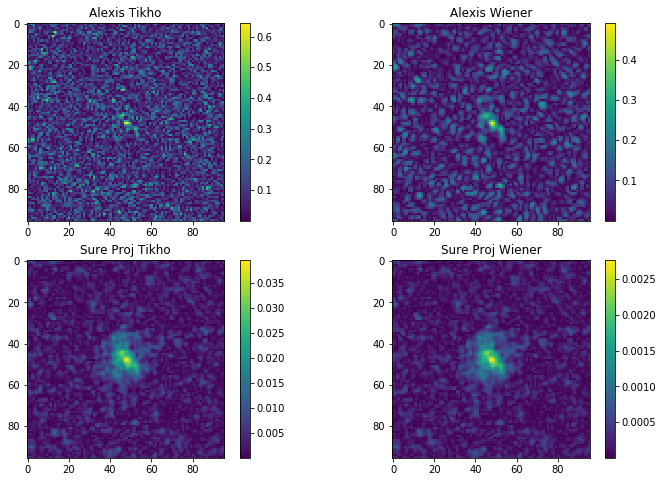

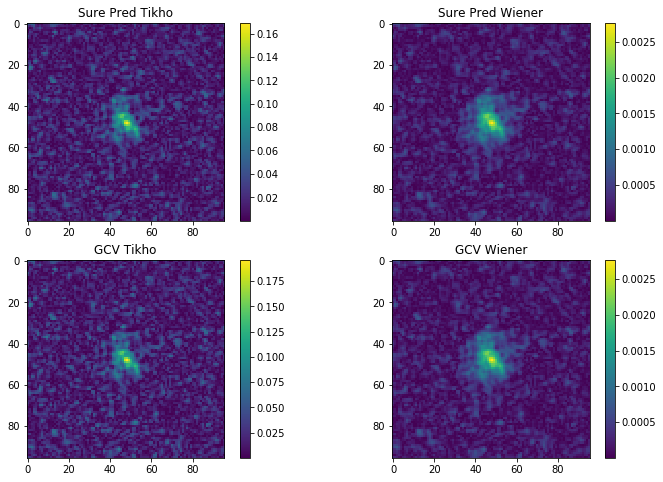

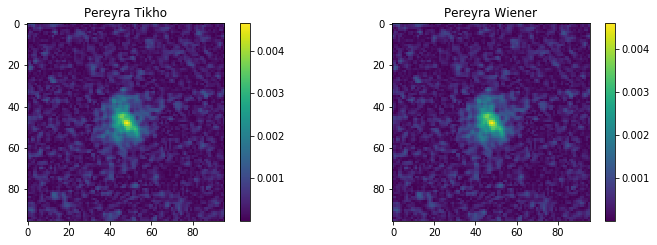

In [546]:
plt.figure()
plt.subplot(221),plt.imshow(np.abs(sol_tik)),plt.colorbar(),plt.title('Alexis Tikho')
plt.subplot(222),plt.imshow(np.abs(sol_wien)),plt.colorbar(),plt.title('Alexis Wiener')
plt.subplot(223),plt.imshow(np.abs(deconv_sure_proj_tikho)),plt.colorbar(),plt.title('Sure Proj Tikho')
plt.subplot(224),plt.imshow(np.abs(deconv_sure_proj_wiener)),plt.colorbar(),plt.title('Sure Proj Wiener')
plt.figure()
plt.subplot(221),plt.imshow(np.abs(deconv_sure_pred_tikho)),plt.colorbar(),plt.title('Sure Pred Tikho')
plt.subplot(222),plt.imshow(np.abs(deconv_sure_pred_wiener)),plt.colorbar(),plt.title('Sure Pred Wiener')
plt.subplot(223),plt.imshow(np.abs(deconv_tikho_gcv)),plt.colorbar(),plt.title('GCV Tikho')
plt.subplot(224),plt.imshow(np.abs(deconv_wiener_gcv)),plt.colorbar(),plt.title('GCV Wiener')
plt.figure()
plt.subplot(221),plt.imshow(np.abs(deconv_tikho_per)),plt.colorbar(),plt.title('Pereyra Tikho')
plt.subplot(222),plt.imshow(np.abs(deconv_wiener_per)),plt.colorbar(),plt.title('Pereyra Wiener')

